<a href="https://colab.research.google.com/github/sitimagfiroh03/Manova/blob/main/Analisis_Perbedaan_Produktivitas%2C_Kepuasan%2C_dan_Kinerja_Proyek_antar_Departemen_dengan_Manova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Analisis Perbedaan Produktivitas, Kepuasan, dan Kinerja Proyek antar Departemen dengan Manova**

In [1]:
!pip install pingouin

In [2]:
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from statsmodels.multivariate.manova import MANOVA

In [3]:
# Untuk hasil yang bisa direplikasi
np.random.seed(42)

# Membuat Tiga departemen
departments = ['Marketing', 'IT', 'Sales']

# Jumlah data per grup secara acak antara 30 s/d 60
n_per_group = {dept: random.randint(30, 60) for dept in departments}

# Rata-rata yang dibedakan antar grup agar signifikan di MANOVA
group_means = {
    'Marketing': [80, 75, 10],  # Productivity, Satisfaction, Projects
    'IT':        [70, 60, 20],
    'Sales':     [85, 65, 15]
}

# Fungsi untuk generate data normal lalu dibulatkan
def generate_group_data(mean_vals, n, std_dev=3):
    return np.round(np.random.normal(loc=mean_vals, scale=std_dev, size=(n, len(mean_vals)))).astype(int)

# Generate dan gabungkan semua data
all_data = []
for dept in departments:
    data = generate_group_data(group_means[dept], n=n_per_group[dept])
    df = pd.DataFrame(data, columns=['Productivity', 'Satisfaction', 'ProjectsCompleted'])
    df['Department'] = dept
    all_data.append(df)

# Gabungkan jadi satu DataFrame
data_manova = pd.concat(all_data, ignore_index=True)

In [4]:
# Simpan ke CSV
data_manova.to_csv('data_manova_fix.csv', index=False)
print("Data berhasil dibuat dan disimpan ke data_manova_fix.csv")

Data berhasil dibuat dan disimpan ke data_manova_fix.csv


In [5]:
data_manova = pd.read_csv("data_manova_fix.csv")
data_manova

,Productivity,Satisfaction,ProjectsCompleted,Department
0,81,75,12,Marketing
1,85,74,9,Marketing
2,85,77,9,Marketing
3,82,74,9,Marketing
4,81,69,5,Marketing
...,...,...,...,...
139,85,69,15,Sales
140,91,70,14,Sales
141,88,67,19,Sales
142,82,67,18,Sales


In [6]:
data_manova = data_manova.rename(columns={
    'Productivity': 'Productivity_Percentage',
    'Satisfaction': 'SatisfactionRate_Percentage',
    'ProjectsCompleted': 'Projects_Completed'
})

In [7]:
data_manova.head()

,Productivity_Percentage,SatisfactionRate_Percentage,Projects_Completed,Department
0,81,75,12,Marketing
1,85,74,9,Marketing
2,85,77,9,Marketing
3,82,74,9,Marketing
4,81,69,5,Marketing


In [8]:
data_manova['Department'].unique()

array(['Marketing', 'IT', 'Sales'], dtype=object)

In [9]:
print(data_manova['Department'].value_counts())

Department
Sales        59
Marketing    53
IT           32
Name: count, dtype: int64


In [10]:
print((data_manova[['Projects_Completed', 'Productivity_Percentage', 'SatisfactionRate_Percentage']] < 0).sum())

Projects_Completed             0
Productivity_Percentage        0
SatisfactionRate_Percentage    0
dtype: int64


### Uji Normalitas Multivariat

In [12]:
# Uji normalitas multivariat
data_Marketing = data_manova.loc[data_manova['Department']=='Marketing', ['Productivity_Percentage', 'SatisfactionRate_Percentage', 'Projects_Completed']]
data_IT = data_manova.loc[data_manova['Department']=='IT', ['Productivity_Percentage', 'SatisfactionRate_Percentage', 'Projects_Completed']]
data_Sales = data_manova.loc[data_manova['Department']=='Sales', ['Productivity_Percentage', 'SatisfactionRate_Percentage', 'Projects_Completed']]

In [13]:
print('Uji Normalitas Multivariat Marketing: ', pg.multivariate_normality(data_Marketing, alpha=0.05))
print('Uji Normalitas Multivariat IT: ', pg.multivariate_normality(data_IT, alpha=0.05))
print('Uji Normalitas Multivariat Sales: ', pg.multivariate_normality(data_Sales, alpha=0.05))

Uji Normalitas Multivariat Marketing:  HZResults(hz=np.float64(35.95409908229583), pval=np.float64(1.5747270585187302e-76), normal=False)
Uji Normalitas Multivariat IT:  HZResults(hz=np.float64(20.323133955133304), pval=np.float64(5.519199759600606e-53), normal=False)
Uji Normalitas Multivariat Sales:  HZResults(hz=np.float64(40.54625459712402), pval=np.float64(1.515209927940031e-82), normal=False)


Berdasarkan p-value dari hasil uji normalitas multivariat, data tidak berdistribusi normal multivariat, sehingga perlu dilakukan transformasi data.

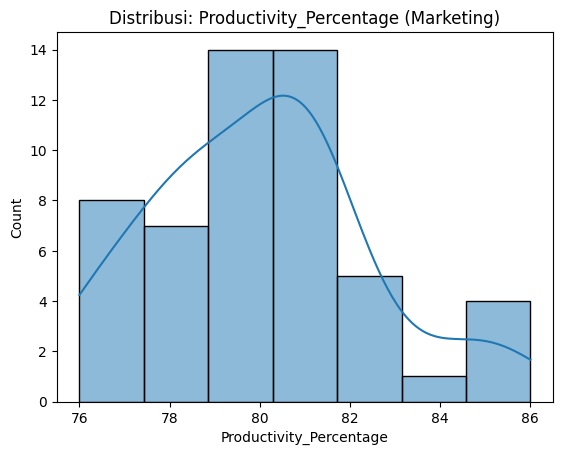

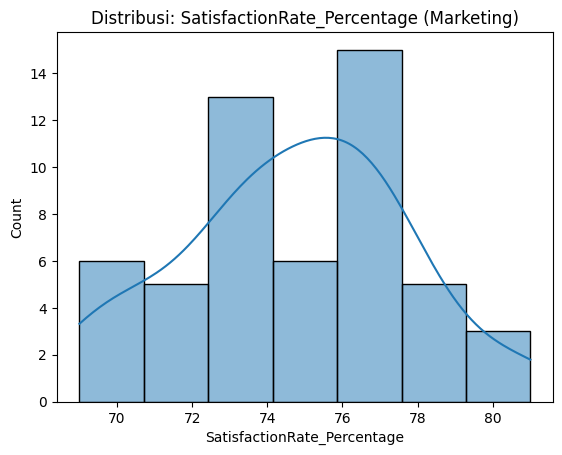

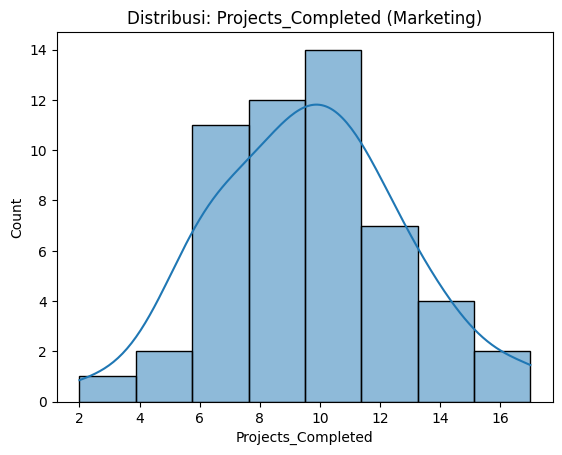

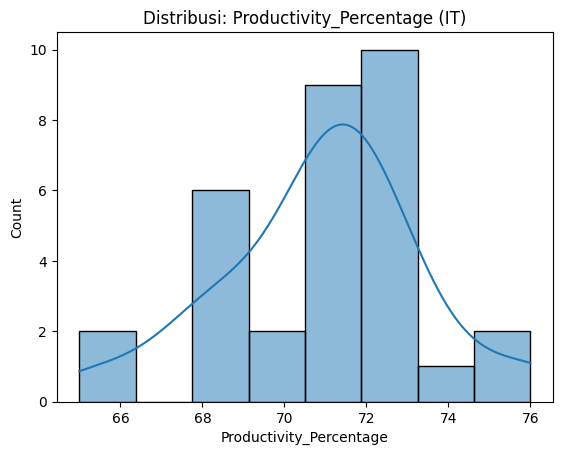

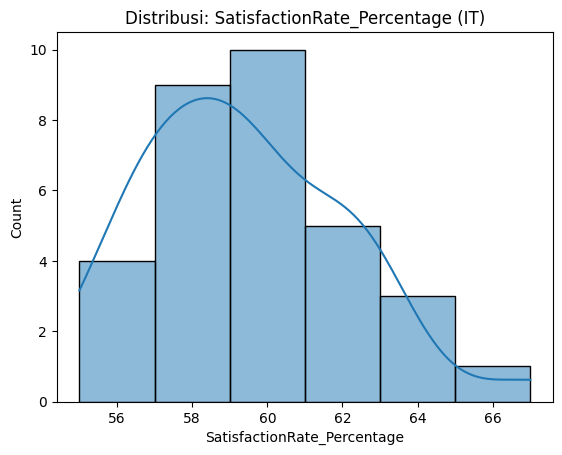

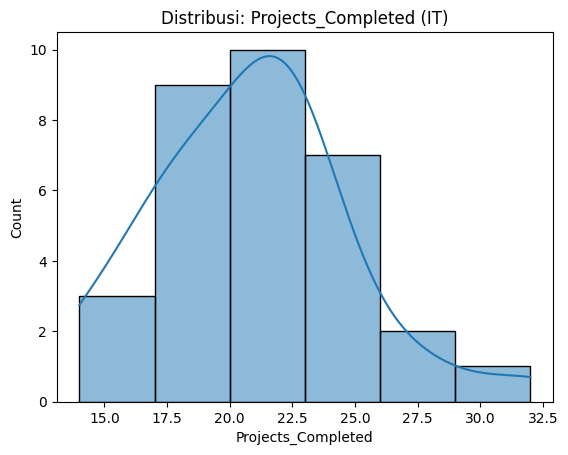

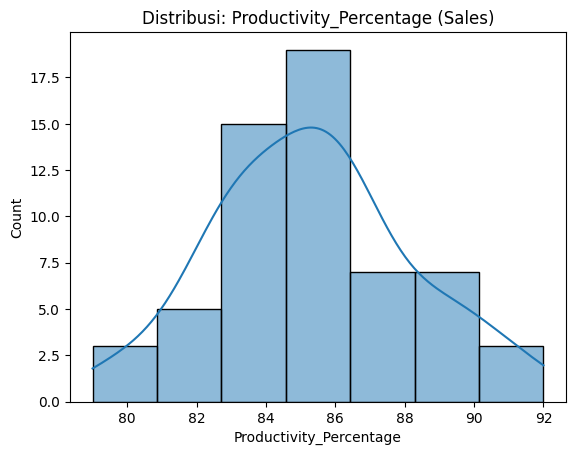

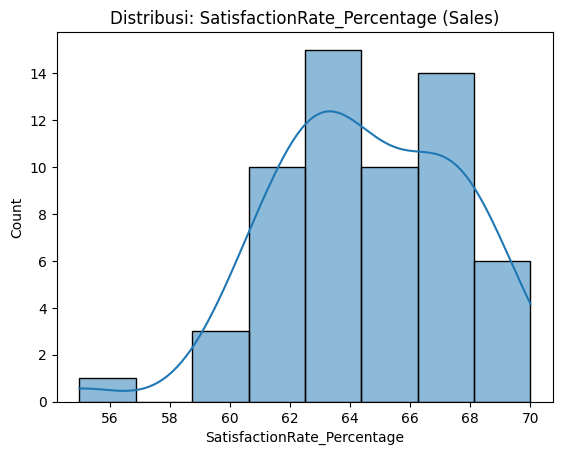

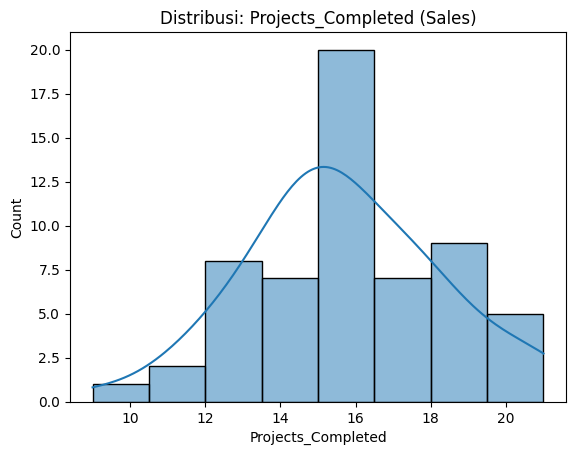

In [14]:
# Distribusi untuk data Marketing
for col in data_Marketing.columns:
    plt.figure()
    sns.histplot(data_Marketing[col], kde=True)
    plt.title(f'Distribusi: {col} (Marketing)')
    plt.show()

# Distribusi untuk data TI
for col in data_IT.columns:
    plt.figure()
    sns.histplot(data_IT[col], kde=True)
    plt.title(f'Distribusi: {col} (IT)')
    plt.show()

# Distribusi untuk data Sales
for col in data_Sales.columns:
    plt.figure()
    sns.histplot(data_Sales[col], kde=True)
    plt.title(f'Distribusi: {col} (Sales)')
    plt.show()

In [15]:
# Transformasi data
data_Marketing_trans = np.sqrt(data_Marketing)
data_IT_trans = np.sqrt(data_IT)
data_Sales_trans = np.sqrt(data_Sales)

Setelah data ditransformasi, lakukan kembali uji normalitas multivariatnya untuk melihat apakah data sudah berdistribusi normal multivariat atau belum.

In [16]:
# Lakukan uji normalitas kembali setelah data ditransformasi
print('Uji Normalitas Multivariat Marketing: ', pg.multivariate_normality(data_Marketing_trans, alpha=0.05))
print('Uji Normalitas Multivariat IT: ', pg.multivariate_normality(data_IT_trans, alpha=0.05))
print('Uji Normalitas Multivariat Sales: ', pg.multivariate_normality(data_Sales_trans, alpha=0.05))

Uji Normalitas Multivariat Marketing:  HZResults(hz=np.float64(0.5821154518702121), pval=np.float64(0.6991881329255483), normal=True)
Uji Normalitas Multivariat IT:  HZResults(hz=np.float64(0.8254098312997971), pval=np.float64(0.08737261916191302), normal=True)
Uji Normalitas Multivariat Sales:  HZResults(hz=np.float64(0.7909804022689565), pval=np.float64(0.20250300744769112), normal=True)


Berdasarkan p-value uji normalitas di atas, ternyata menunjukkan bahwa semua p-value ≥ 0.05, artinya data berdistribusi normal multivariat.

### Uji Homogenitas

In [17]:
# Gabungkan lagi datanya
data_trans_manova = pd.concat([data_Marketing_trans, data_IT_trans, data_Sales_trans])
data_trans_manova['Department'] = data_manova['Department'].copy()
data_trans_manova

,Productivity_Percentage,SatisfactionRate_Percentage,Projects_Completed,Department
0,9.000000,8.660254,3.464102,Marketing
1,9.219544,8.602325,3.000000,Marketing
2,9.219544,8.774964,3.000000,Marketing
3,9.055385,8.602325,3.000000,Marketing
4,9.000000,8.306624,2.236068,Marketing
...,...,...,...,...
139,9.219544,8.306624,3.872983,Sales
140,9.539392,8.366600,3.741657,Sales
141,9.380832,8.185353,4.358899,Sales
142,9.055385,8.185353,4.242641,Sales


In [18]:
# Uji Homogenitas
pg.box_m(data_trans_manova, dvs=['Productivity_Percentage', 'SatisfactionRate_Percentage', 'Projects_Completed'], group='Department')

,Chi2,df,pval,equal_cov
box,18.158517,12.0,0.110961,True


Berdasarkan hasil "equal_cov = True", menandakan bahwa asumsi homogenitas kovarian terpenuhi. Sehingga data dianggap sudah homogen.

### Manova

In [19]:
manova_model = MANOVA.from_formula('Productivity_Percentage + SatisfactionRate_Percentage + Projects_Completed ~ Department', data=data_trans_manova)
manova_results = manova_model.mv_test()
print(manova_results)

                     Multivariate linear model
                                                                   
-------------------------------------------------------------------
       Intercept          Value   Num DF  Den DF   F Value   Pr > F
-------------------------------------------------------------------
          Wilks' lambda    0.0008 3.0000 139.0000 56489.5676 0.0000
         Pillai's trace    0.9992 3.0000 139.0000 56489.5676 0.0000
 Hotelling-Lawley trace 1219.1993 3.0000 139.0000 56489.5676 0.0000
    Roy's greatest root 1219.1993 3.0000 139.0000 56489.5676 0.0000
-------------------------------------------------------------------
                                                                   
-------------------------------------------------------------------
           Department        Value  Num DF  Den DF  F Value  Pr > F
-------------------------------------------------------------------
              Wilks' lambda  0.0287 6.0000 278.0000 227.3916 0.0000
 

Berdasarkan Pr > F dari hasil uji Manova di atas, menunjukkan bahwa keempat statistik uji (Wilks' lambda, Pillai's trace, Hotelling-Lawley trace, Roy's greatest root) memiliki nilai p yang sangat kecil yaitu Pr > F = 0.0000. Artinya, terdapat perbedaan yang signifikan secara multivariat antara Department terhadap variabel-variabel dependen yang dianalisis.

### Uji Post Hoc

In [20]:
tukey_Productivity_Percentage = pg.pairwise_tukey(data=data_trans_manova, dv='Productivity_Percentage', between='Department')
print("Tukey Post-hoc untuk variabel Productivity_Percentage")
tukey_Productivity_Percentage

Tukey Post-hoc untuk variabel Productivity_Percentage


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,IT,Marketing,8.419370,8.943282,-0.523912,0.032458,-16.141387,0.0,-3.747107
1,IT,Sales,8.419370,9.235735,-0.816365,0.031830,-25.647432,0.0,-5.365996
2,Marketing,Sales,8.943282,9.235735,-0.292453,0.027439,-10.658363,0.0,-2.004680


In [21]:
tukey_SatisfactionRate_Percentage = pg.pairwise_tukey(data=data_trans_manova, dv='SatisfactionRate_Percentage', between='Department')
print("Tukey Post-hoc untuk variabel SatisfactionRate_Percentage")
tukey_SatisfactionRate_Percentage

Tukey Post-hoc untuk variabel SatisfactionRate_Percentage


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,IT,Marketing,7.70566,8.641110,-0.935450,0.040606,-23.037211,0.000000e+00,-5.358092
1,IT,Sales,7.70566,8.031554,-0.325894,0.039821,-8.183931,4.215517e-13,-1.735838
2,Marketing,Sales,8.64111,8.031554,0.609556,0.034327,17.757208,0.000000e+00,3.296820


In [22]:
tukey_Projects_Completed = pg.pairwise_tukey(data=data_trans_manova, dv='Projects_Completed', between='Department')
print("Tukey Post-hoc untuk variabel Projects_Completed")
tukey_Projects_Completed

Tukey Post-hoc untuk variabel Projects_Completed


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,IT,Marketing,4.543036,3.060704,1.482332,0.096908,15.296313,0.000000e+00,2.988841
1,IT,Sales,4.543036,3.943728,0.599307,0.095035,6.306201,1.034206e-08,1.623768
2,Marketing,Sales,3.060704,3.943728,-0.883024,0.081923,-10.778679,0.000000e+00,-2.013197


Berdasarkan p-tukey pada uji Post Hoc, menunjukkan bahwa terdapat perbedaan yang signifikan antara setiap pasangan departemen (p-tukey < 0.05) pada ketiga variabel yaitu Productivity_Percentage, SatisfactionRate_Percentage, dan Projects_Completed.

### Visualisasi

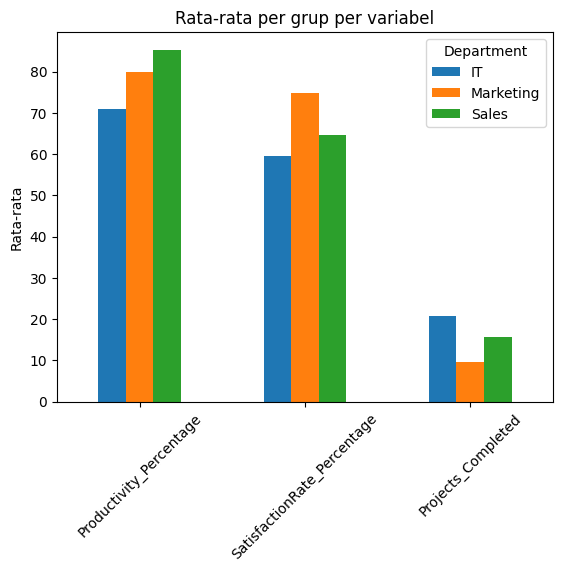

In [23]:
data_manova.groupby('Department')[['Productivity_Percentage', 'SatisfactionRate_Percentage', 'Projects_Completed']].mean().T.plot(kind='bar')
plt.title('Rata-rata per grup per variabel')
plt.ylabel('Rata-rata')
plt.xticks(rotation=45)
plt.show()

Berdasarkan visualisasi tersebut, terlihat bahwa Department Sales menunjukkan performa paling unggul secara keseluruhan, dengan Produktivitas tertinggi dan Tingkat Kepuasan Kerja serta jumlah Proyek terselesaikan  yang baik.